In [70]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/jl_files/zz_samplers.jl")
include("temp.jl")

run_sampler (generic function with 4 methods)

In [2]:
n_groups, group_size = 2, 10
Nobs = group_size*n_groups
d = 2
dim_total = 1+n_groups+d

σ02 = 1
my_pr = MM_prior(d, n_groups, σ02)

pX = 5e-1
X = spzeros(dim_total, Nobs)
X[1,:] = 1
for group in 1:n_groups
    X[group+1,((group-1)*group_size+1):(group*group_size)] = 1
end
X[n_groups+2:end,:] = sprandn(d, Nobs, pX)
ξ_true = rand(Normal(),dim_total)
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) for j in 1:Nobs])

my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

In [135]:
save("data_simple.jld", "X", X, "y", y)

In [12]:
max_attempts = 2*10^7
lambda_list = Float32.(logspace(-2,0.3,10))
Print = false
mb_size = 10;

In [13]:
start_overall = time()
for lambda in lambda_list 
    start = time()
    run_sampler(my_model, lambda, max_attempts, mb_size, Print) 
    print("Sampling for lambda = ", round(lambda,2), " in ", round((time()-start)/60,1), " mins \n")
end
print("Overall in ", round((time()-start_overall)/60,1), " mins")

Sampling for lambda = 0.01 in 46.7 mins 
Sampling for lambda = 0.02 in 46.7 mins 
Sampling for lambda = 0.03 in 46.0 mins 
Sampling for lambda = 0.06 in 46.7 mins 
Sampling for lambda = 0.11 in 47.0 mins 
Sampling for lambda = 0.19 in 45.6 mins 
Sampling for lambda = 0.34 in 45.1 mins 
Sampling for lambda = 0.62 in 45.2 mins 
Sampling for lambda = 1.11 in 45.6 mins 
Sampling for lambda = 2.0 in 46.3 mins 
Overall in 460.9 mins

In [97]:
lambda_list_extended = Float32.(logspace(0.3,0.3+2.3/(9/5),6));
print(log.(lambda_list)[2:end] - log.(lambda_list)[1:end-1], "\n")
print(log.(lambda_list_extended)[2:end] - log.(lambda_list_extended)[1:end-1])

Float32[0.588439, 0.588438, 0.588439, 0.588439, 0.588438, 0.588438, 0.588438, 0.588438, 0.588438]
Float32[0.588438, 0.588439, 0.588439, 0.588438, 0.588438]

In [98]:
start_overall = time()
for lambda in lambda_list_extended[2:end]
    start = time()
    run_sampler(my_model, lambda, max_attempts, mb_size, Print) 
    print("Sampling for lambda = ", round(lambda,2), " in ", round((time()-start)/60,1), " mins \n")
end
print("Overall in ", round((time()-start_overall)/60,1), " mins")

Sampling for lambda = 3.59 in 55.0 mins 
Sampling for lambda = 6.47 in 59.6 mins 
Sampling for lambda = 11.66 in 67.3 mins 
Sampling for lambda = 21.0 in 79.0 mins 
Sampling for lambda = 37.82 in 98.0 mins 
Overall in 358.8 mins

In [111]:
lambda_list_new = Float32.(zeros(15))
lambda_list_new[1:10], lambda_list_new[11:15] = lambda_list, lambda_list_extended[2:end];

In [115]:
size(lambda_list_new)

(15,)

1. lambda = 0.01 slowest mixing = 54.569
2. lambda = 0.02 slowest mixing = 30.864
3. lambda = 0.03 slowest mixing = 15.977
4. lambda = 0.06 slowest mixing = 10.51
5. lambda = 0.11 slowest mixing = 6.91
6. lambda = 0.19 slowest mixing = 5.25
7. lambda = 0.34 slowest mixing = 3.425
8. lambda = 0.62 slowest mixing = 2.845
9. lambda = 1.11 slowest mixing = 2.064
10. lambda = 2.0 slowest mixing = 1.837
11. lambda = 3.59 slowest mixing = 1.717
12. lambda = 6.47 slowest mixing = 1.714
13. lambda = 11.66 slowest mixing = 1.701
14. lambda = 21.0 slowest mixing = 1.711


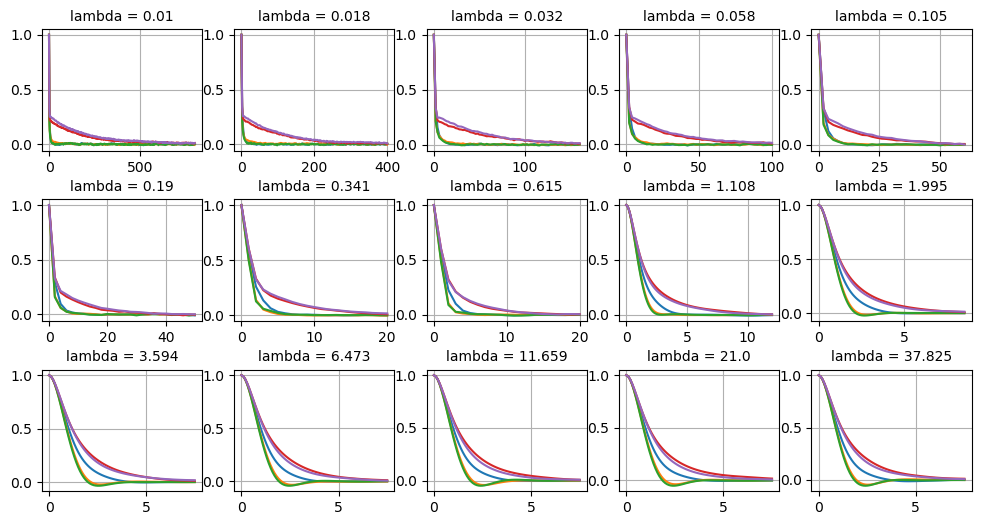

15. lambda = 37.82 slowest mixing = 1.684


In [128]:
fig = figure("pyplot_barplot",figsize=(12,6))
n_samples = 10^5-1
maxlags = [400,200,80,50,30,25,20,20,120,85,75,75,75,75,75]
h_list = [2,2,2,2,2,2,1,1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1]
discard = 0
iacts = zeros(15)
for j in 1:3 
    for i in 1:5
        k = (j-1)*5+i
        lambda = lambda_list_new[k]
        filename = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
                    "-dim_cov:"*string(d)*"-n_groups:"*string(n_groups)*
                    "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
        
        xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
#         h = (bt_skel[end]-bt_skel[discard+1])/n_samples
        h = h_list[k]
        xi_samples = extract_samples(xt_skel[:,discard+1:end], 
                                     bt_skel[:,discard+1:end], 
                                     h,"linear")[:,1:end-1];
        subplot(3,5,k)
        maxlag = maxlags[k]
        for dim in 1:size(xi_samples,1)
            plot(h*(0:maxlag), acf(xi_samples[dim,:],maxlag))
            title("lambda = "*string(round(lambda,3)), fontsize=10)
            grid(true)
        end
        iacts[k] = maximum([sum(acf(xi_samples[dim,:],maxlag)) for dim in 1:size(xi_samples,1)])
        print(k, ". lambda = ", round(lambda,2), " slowest mixing = ", 
               round(h*iacts[k],3), "\n")
        xt_skel, bt_skel, xi_samples = [], [], []
        gc()
    end
end
subplots_adjust(hspace=0.4)

In [129]:
for j in 1:3
    for i in 1:5
        k = (j-1)*5+i
        maxlag = maxlags[k]
        lambda = lambda_list_new[k]
        filename = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
                    "-dim_cov:"*string(d)*"-n_groups:"*string(n_groups)*
                    "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
        
        bt_skel = load(filename, "bt_skeleton")
        print(round(bt_skel[1,end],1), "\n")
    end
end

235189.5
234939.3
235211.6
235117.3
234933.9
234398.2
233507.9
232336.5
230179.0
227793.1
223361.7
216205.6
204537.3
186531.3
161434.6


In [136]:
print(iacts)

[27.2843, 15.4322, 7.98854, 5.25504, 3.45509, 2.62506, 3.425, 2.84548, 20.6428, 18.3736, 17.1654, 17.1373, 17.0079, 17.1105, 16.8393]

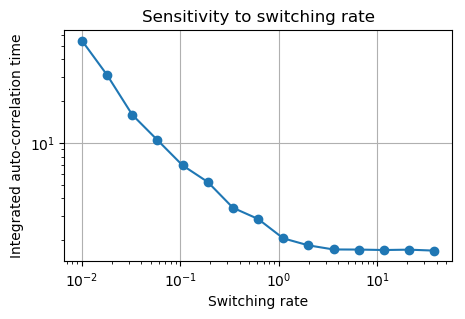

In [133]:
fig = figure("pyplot_barplot",figsize=(5,3))
plot(lambda_list_new, h_list.*iacts, "o-")
# plot(lambda_list_new, 1./log.(1+lambda_list_new), label="theory")
xscale("log")
yscale("log")
xlabel("Switching rate")
ylabel("Integrated auto-correlation time")
title("Sensitivity to switching rate")
grid(true)